In [ ]:
import numpy as np 
import math

class layout: 
  def __init__ (self, m: int, shape: tuple[int, ...], stride: tuple[int, ...]): 
    if (len(shape) != m) or (len(stride) != m): 
      raise ValueError("m is the dimensionality, both the shape and stride must be an m-tuple")
    assert shape[0] > 0 
    assert stride[0] > 0
    for i in range(1,m): 
      assert isinstance(shape[i], int)  | isinstance(shape[i], np.int64)
      assert isinstance(stride[i], int)  | isinstance(stride[i], np.int64)
      assert shape[i] > 1
      assert stride[i] > 0
      
    self.m = m 
    self.N = np.prod(shape).item()
    self.shape = np.array(shape)
    self.stride = np.array(stride)
    
    shape_stride = [1 for i in range(m)] 
    for i in reversed(range(m-1)): 
      shape_stride[i] = shape[i+1]*shape_stride[i+1]
      
    self.shape_stride = np.array(shape_stride)
    self.one_d_domain = np.arange(self.N)
    self.fan_map = (self.one_d_domain.reshape(self.N,1) // self.shape_stride.reshape(1, self.m)) % (self.shape.reshape(1, self.m))
    #the shape of the fan map is (N, m) the reason being, each one d element is a position in N (the outermost) dimension
    #the rest of the inner dimensions, is the literal m_tuple co-ordinate of that that one. that is: 
    #fan_map(i) (which is a tuple depicting co-oridnates)  =  tuple(self.fan_map[i]) (as a numpy slice)
    #the fan map itself, simply presents a row major layout ordering. 
    #the stride now, is going to induce the map from the m_tuple, back to the 1d. so composed, we get the layout
    self.layout = np.sum(self.fan_map * self.stride.reshape(1, self.m), axis = 1)
    n_warps = math.ceil(self.N/32.0) 
    n_lanes = 32
    self.pad_amount = (n_warps*n_lanes) - self.N 
    self.padded_layout = np.pad(self.layout, (0, self.pad_amount))
    
    self.bank_conflicts = np.zeros((n_warps,n_lanes)).astype(int)
    self.layout_bank_id = (self.padded_layout.reshape(n_warps, n_lanes) % 32)
    for i in range(n_warps): 
      for j in range(n_lanes): 
        if (i*32 + j < self.N):
          self.bank_conflicts[i, self.layout_bank_id[i,j]] += 1
        
        
    self.perm = [i for i in range(self.m)] 
    self.sorted_stride = list(stride)
    for i in range(self.m-1): 
      for j in range(i+1, self.m):
        if self.sorted_stride[i] <= self.sorted_stride[j]: 
          p_i = self.perm[i]
          p_j = self.perm[j]
          s_i = self.sorted_stride[i]
          s_j = self.sorted_stride[j]
          self.perm[i], self.perm[j] = p_j, p_i
          self.sorted_stride[i], self.sorted_stride[j] = s_j, s_i
          
    self.sorted_shape = [self.shape[self.perm[i]] for i in range(self.m)]
    self.is_injective = True 
    unique_len = np.unique(self.layout).size
    layout_len = self.layout.size
    if unique_len < layout_len: self.is_injective = False
    self.layout_injective = True 
    if self.sorted_stride[self.m-1] < 1: 
      self.layout_injective = False 
      
    for j in reversed(range(self.m - 1)): 
      if self.sorted_stride[j] < self.sorted_stride[j+1]*self.sorted_shape[j+1]: 
        self.layout_injective = False
        break
    
  def __repr__(self):
    return (f"N_elements = {self.N} \n"
            f"layout(m={self.m}, \n"
            f"       shape={self.shape}, \n"
            f"       stride={self.stride}, \n"
            f"       shape_stride = {self.shape_stride})")
    
  

In [14]:
def swizzle(b_bits:int, m_base:int, s_shift:int, X: int):
  assert b_bits >= 0 
  assert m_base >= 0 
  assert abs(s_shift) >= abs(b_bits) 
  
  base_mask = (1 << b_bits) - 1
  yy_shift = m_base + max(0,s_shift);
  zz_shift = m_base - min(0,s_shift); 
  
  yy_mask = (base_mask) << yy_shift
  zz_mask = (base_mask) << zz_shift 
  swizzle_code = yy_mask | zz_mask 
  swizzled_X = X & yy_mask
  if s_shift > 0: 
    swizzled_X = X ^ (swizzled_X >> abs(s_shift))
  else: 
    swizzled_X = X ^ (swizzled_X << abs(s_shift))
    
  
  
  return swizzle_code, swizzled_X
  
def print_bin(N:int, w:int = 32):
  print(f"{N:0{w}b}")

In [17]:
X = 65
b_bits = 5
m_base = 0
s_shift = 6

In [18]:
code, out = swizzle(b_bits, m_base, s_shift, X)

In [20]:
print_bin(X)
print_bin(code)
print_bin(out)

00000000000000000000000001000001
00000000000000000000011111011111
00000000000000000000000001000000


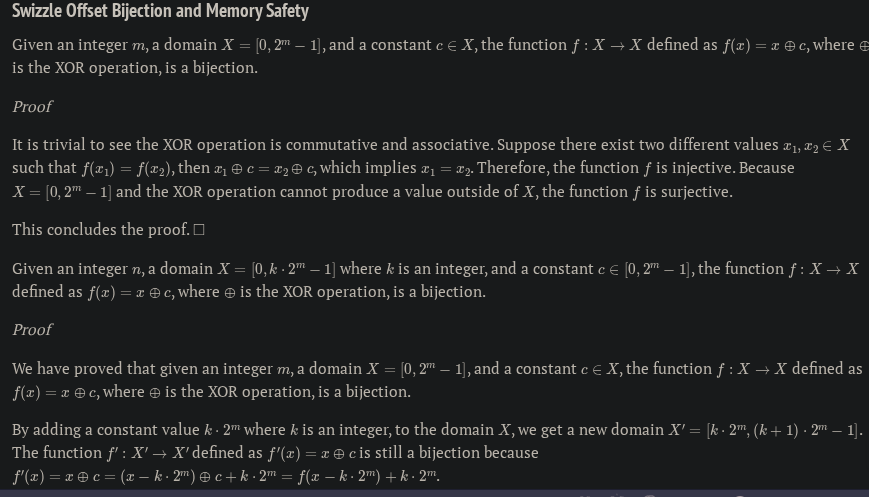

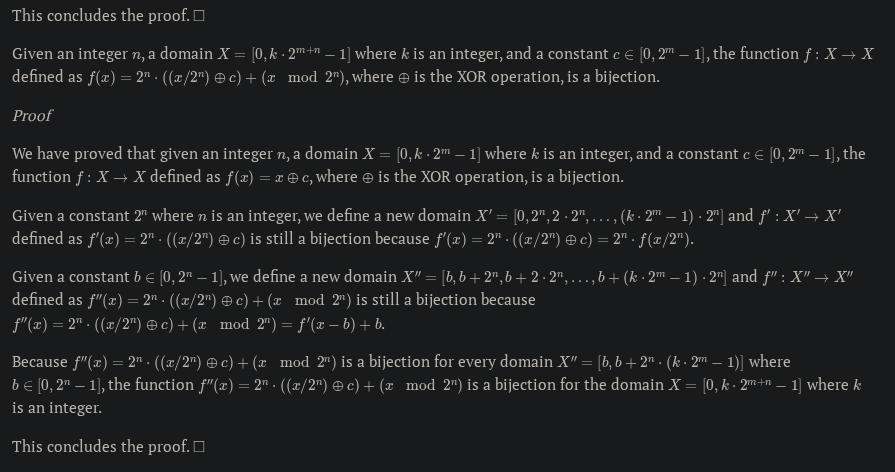

A layout $L =  S:D$ is said to be "canconically injective" if $D$ is non inscreasing (unstrictly decreasing) 
and for each $k \in [0,m-2]$, $D_k \ge D_{k+1} S_{k+1}$ and $D_{m-1} > 0$. 

A layout is injective if and only if there exists some permutation $\pi$ of the indicies for which $L^{\pi} = S^{\pi} : D^{\pi}$ is canconically injective. 

Hence, if a layout is injective, all of its permuted layouts are injective. this follows because if $\pi$ is a permutation for which $L^{\pi}$ is canonically injective (equivalent to $L$ being injective) and if $q$ is any permutation, then $\pi \circ q^{-1}$ is the permutation for which $L^{q}$ is canonically injective.

And indeed the swizzle functions are bijective. so what do we do? 

we let $m \le 4$, generate all permutations of $[0..3]$ and for each of them, compute the permuted shapes and strides, restrict the number of elements, compute layout, and post swizzled layout. 

In [33]:
import numpy as np
import math
import itertools as it 

class Layout: 
  def __init__ (self, m:int, S:np.ndarray, D:np.ndarray, b_bits:int, m_base:int, s_shift:int):
    assert m <= 4
    assert S.shape == (m,)
    assert D.shape == (m,)
    assert b_bits >= 0 
    assert m_base >= 0
    assert abs(s_shift) >= b_bits 
    assert np.prod(S).item() <= 64
    assert np.prod(D).item() <= 64
    self.m = m 
    self.b_bits = b_bits
    self.m_base = m_base 
    self.s_shift = s_shift
    
    self.N_perms = self._fac(m)
    self.perms = self._generate_perms(m, self.N_perms)
    self.S_perms = self._apply_perms(S, self.perms, self.m, self.N_perms)
    self.D_perms = self._apply_perms(S, self.perms, self.m, self.N_perms)
    self.N_elems = np.prod(S).item()
    self.flat_domain = np.arange(self.N_elems)
    
    shape_stride = np.array([1 for i in range(m)]) 
    for i in reversed(range(m-1)): 
      shape_stride[i] = S[i+1]*shape_stride[i+1]
    
    self.S_stride_perms = self._apply_perms(shape_stride, self.perms, self.m, self.N_perms)    
    self.fan_out_maps = ((self.flat_domain.reshape(1,self.N_elems,1)) // (self.S_stride_perms.reshape(self.N_perms, 1, self.m))) % (self.S_perms.reshape(self.N_perms, 1, self.m))
    self.layouts = np.sum(self.D_perms.reshape(self.N_perms, 1, self.m) * self.fan_out_maps, axis = -1)

    
    
  def _fac (self, n): 
    return np.prod(np.arange(n+1)[1:n+1]).item()
  
  def _generate_perms(self, n, n_perms):
    perms = np.zeros((n_perms, n)).astype(int)
    i = 0
    for p in it.permutations(range(n)): 
      perms[i] = np.array(p)
      i+= 1
      
    return perms
      
  def _apply_perms(self, X, perms, n, n_perms): 
    applied_perms = np.zeros((n_perms, n)).astype(int)
    for i in range(n_perms): 
      applied_perms[i] = X[perms[i]]
      
    return applied_perms
  
     
    
    

In [40]:
S = np.array([3,4,2])
D = np.array([3,7,2])
m = 3
b_bits = 1 
m_base = 2
s_shift = 3

L = Layout(m,S,D,b_bits, m_base, s_shift)
L.N_perms
L.S_perms
L.S_stride_perms
L.layouts


array([[ 0,  2,  4,  6,  8, 10, 12, 14,  3,  5,  7,  9, 11, 13, 15, 17,
         6,  8, 10, 12, 14, 16, 18, 20],
       [ 0,  2,  4,  6,  8, 10, 12, 14,  3,  5,  7,  9, 11, 13, 15, 17,
         6,  8, 10, 12, 14, 16, 18, 20],
       [ 0,  2,  4,  6,  8, 10, 12, 14,  3,  5,  7,  9, 11, 13, 15, 17,
         6,  8, 10, 12, 14, 16, 18, 20],
       [ 0,  2,  4,  6,  8, 10, 12, 14,  3,  5,  7,  9, 11, 13, 15, 17,
         6,  8, 10, 12, 14, 16, 18, 20],
       [ 0,  2,  4,  6,  8, 10, 12, 14,  3,  5,  7,  9, 11, 13, 15, 17,
         6,  8, 10, 12, 14, 16, 18, 20],
       [ 0,  2,  4,  6,  8, 10, 12, 14,  3,  5,  7,  9, 11, 13, 15, 17,
         6,  8, 10, 12, 14, 16, 18, 20]])

OH WOW! if you permute the whole layout, the layout map doesn't change. Intuitively this makes sense, the fan out map $F$ takes an int $x$ 
to a tuple $Tx$ using the shape, but if you permute the shape, then $Tx'$ is obtained by applying the same permutation to the tutple $Tx$ 
ie $Tx'[i] = Tx[q(i)]$ for some perm $q$. hence, we write $Tx' = q(Tx)$. take the stride flattening map $g_q$ that uses the permuted strides on both sides. $g_q (Tx') = g_q(q(Tx))$ but $g_q(Tx') = l_q(x)$, the permuted layout map applied to the number $x$. 
And, $$ g_q(q(Tx)) = \sum_{k=0}^{m-1} D^q[k] \times (q(Tx))[k]$$

But, $(q(Tx))[k] = Tx[q^{-1}(k)]$ and $D^q[k] = D[q^{-1}(k)]$  
hence, 


$$ g_q(q(Tx)) = \sum_{k=0}^{m-1} D[q^{-1}(k)] \times Tx[q^{-1}(k)] $$

But sums don't care about permutations, so really $$ g_q(q(Tx)) = l(x) $$ the layout map of the unpermuted layout $L$. 

Therefore we have $l_q(x) = l(x)$ for each $x$. 

So we will keep shape fixed, and permute the strides. 

Why? because suppose $L = S:D$ is a layout and $p,q$ are perms then define $L^{p,q} = S^{p} : D^{q} = L_*$

we know that the layout map of $L_*$, $l^*$ is equal to any layout map $l^*_{\pi}$ of permuted layout $L_*^{\pi}$
setting ${\pi} = p^{-1}$ we say that the layout map of $L^{p,q}$ is equal to the layout map of $L^{id , p^{-1} \circ q}$, which is a layout 
where only the stride is permuted. 

That is for all perms $p,q$ there is a layout with only the stride permuted (by $p^{-1} \circ q$), whose layout map is equal to the layout map of the layout who is obtained by permuting the shape with $p$ and stride with $q$. 



In [ ]:
import numpy as np
import math
import itertools as it 

class Layout: 
  def __init__ (self, m:int, S:np.ndarray, D:np.ndarray, b_bits:int, m_base:int, 
                s_shift:int, warp_size:int, smem_word_width:int, 
                element_vector_size:int, element_type_width:int, address_atom_width:int, n_banks:int):
    assert m <= 4
    assert S.shape == (m,)
    assert D.shape == (m,)
    assert b_bits >= 0 
    assert m_base >= 0
    assert abs(s_shift) >= b_bits 
    assert np.prod(S).item() <= 64
    assert np.prod(D).item() <= 64
    self.m = m 
    self.b_bits = b_bits
    self.m_base = m_base 
    self.s_shift = s_shift
    
    self.N_perms = self._fac(m)
    self.perms = self._generate_perms(m, self.N_perms)
    self.S = S
    self.D_perms = self._apply_perms(S, self.perms, self.m, self.N_perms)
    self.N_elems = np.prod(S).item()
    self.flat_domain = np.arange(self.N_elems)
    
    shape_stride = np.array([1 for i in range(m)]) 
    for i in reversed(range(m-1)): 
      shape_stride[i] = S[i+1]*shape_stride[i+1]
    
    self.S_stride = shape_stride 
    self.fan_out_map = ((self.flat_domain.reshape(1,self.N_elems,1)) // (self.S_stride.reshape(1, 1, self.m))) % (self.S.reshape(1, 1, self.m))
    self.layouts = np.sum(self.D_perms.reshape(self.N_perms, 1, self.m) * self.fan_out_map, axis = -1)

    
    
  def _fac (self, n): 
    return np.prod(np.arange(n+1)[1:n+1]).item()
  
  def _generate_perms(self, n, n_perms):
    perms = np.zeros((n_perms, n)).astype(int)
    i = 0
    for p in it.permutations(range(n)): 
      perms[i] = np.array(p)
      i+= 1
      
    return perms
      
  def _apply_perms(self, X, perms, n, n_perms): 
    applied_perms = np.zeros((n_perms, n)).astype(int)
    for i in range(n_perms): 
      applied_perms[i] = X[perms[i]]
      
    return applied_perms
  
  def _layout_to_smem_addr(self, n_perms, n_elems, layout, vector_size, element_type_width, smem_word_width, address_atom_width):
    S, ew, sw, aw = vector_size, element_type_width, smem_word_width, address_atom_width
      
    N = ew*S 
    max_n_addr_atoms = ((N-2)//aw) + 2 
    G = sw//aw 
    max_n_smem_addrs = (max_n_addr_atoms - 2)//G + 2
    
    layout_to_smem_addr_map = -np.ones((n_perms, n_elems, max_n_smem_addrs)).astype(int)
    
    for i in range(n_perms): 
      for j in range(n_elems): 
        slice = self._abs_vec_addr_to_smem_addr_set(layout[i,j], S, ew, sw, aw)
        n_actual = np.size(slice)
        layout_to_smem_addr_map[i,j,0:n_actual] = slice
        
    return layout_to_smem_addr_map
  

  def _abs_vec_addr_to_smem_addr_set (self, vec_addr: int, vector_size: int, 
                                    element_type_width: int, smem_word_width:int, address_atom_width:int):
    
    v, S, ew, sw, aw = vec_addr, vector_size, element_type_width, smem_word_width, address_atom_width 
    Q  = np.arange(S) 
    abs_scalar_addr = (v*S) + Q
    EW = np.arange(ew).reshape(ew,1)
    bit_addrs = EW + (ew*abs_scalar_addr)
    atom_addrs = bit_addrs//aw
    smem_addrs = atom_addrs//(sw//aw)

    smem_addr_set_actual = np.unique(smem_addrs.flatten())
    
  
    return smem_addr_set_actual



The standing assumption is that, there are n_elems number of threads, and thread i maps to element i indentically and bijectively, 
now, somehow, we need to go from the layout shape (n_perms, n_elemes = n_threads) to (n_perms, n_threads, n_smem_words_per_element)
and indeed that second np array is telling, okay, for this layout, for each of its stride permutations, the thread $i$ is mapped to 
these smem_words. That is our address map. 

so how do we do that? 

first of all, for now, there are no loops, so each thread maps to a contiguous vector element. 
Step 1: if $l(i)$ is the "abstract vector address" that thread $i$ maps to, then its "abstract scalar address sequence" is calculated as: 
  (let $V_w$ denote the number of scalar elements in our vector element, ie elem_vector_size) 

  Then, $l(i) \mapsto EL(i) = <V_w l(i) + 0, V_w l(i) + 1, ... V_w l(i) + (V_w -1)>$

  So $EL(i)$ is now a tuple. containing abstract scalar addresses. 
  next, we need to replace $EL(i)_k$ with the sequence of shared memory addresses it holds 

  let $E_w$ denote the width of out scalar type, ie elem_type_width. 

  let $S_w$ denote the with of our shared memory address ie smem_word_width 
  let $Q$ be the number of smem words per element (asuming tight contigous packing)
  let $A$ be the adress atom width. 

  The assumption is that every $A$ bits has a physical address on the machine. so we need to respect that. 
  We can't address in between the adress atom width. 

  We also assume everything has a base address of $0$ and offset and adress are equivalent. 

so an element $e$ maps to bits $BB = E_w e, E_w e +1, ... E_w e + (E_w -1)$ 
the map of address atoms then becomes $BB // A$ (elementwise floor) 
Then finally, we know that in terms of number of atoms, the width of an smem word is $G  = S_w//A$. 
Hence finally, we have $SMB = BB // A // G$. lets code it for clarity lol 




For checking bank conflicts, Indeed we don't give two fucks about which element in the vector hits which smem word, we just care about hey, this is the set of smem words that this vector element hits. two scalar elements cant overlap in storage in terms of raw bits itself, and smem transactions are in the UNIT of smem words, we always load each smem word only once per scalar element of vector, (again, the compiler must be really smart to get the elements out of the words I guess, however, for most purposes it is straight forward, everything is 8,16,32, 2 floats, 4 floats type shit, which reduces complexity).

why? 

imagine A vector element $V$ has scalar elements $V_0, V_1,... V_{n-1}$ due to contiguity of vector elements, we know that the the smem address sequence of each $V_i$ is increasing, moreover, the smem address sequences of two subsequent scalar elements can overlap across atmost 1 smem addreess word, cause again, the scalar elements themselves are arranged in increasing address sequences. EVERYTHING, such as striding, skipping, swizzling, happens on the unit of vector address in this model. (Ill put a pic below)


So we care only about the SET (unquiue) of smem addrs that a vector element hits. 
So how BIG can that set be? (we just need rough bounds, cause we will pad with NANs or something anyway)

Well, worst case, element size is $E_w$ and smem word size is $S_w$ and we overlap with the prev smem word on the left corner
and the next smem word on the right corner which is roughly ceil(E_w/S_w) + 1 TIMES the number of elements in my vector.

Okay wait the above bound is fucking nuts, lets not do that, let us have $n$ scalars in our vector, then the number of raw bit addresses is $n*E_w$, but then the max number of address atoms is $Q = ceildiv(n*E_w, a_w)$ and hence the max number of smem addresses is again $ceildiv(Q, S_w // a_w)$.

But this bound is an underestimate, cause we have missed the case where left side and right side have misalignments. 

####### Worst case container span problem: 

let $X$ be the number of stones. and suppose we have an infinite number of contains with capacity at most $C$ stones, arranged in a line. We need to fill a contigous row of containers with the following rules:

only the first and last container can be filled to less than full capacity. 
every container in between must be filled to full capacity. And it is again a standing assumption that $X > C$ cause otherwise just fill one lmao. 

What is the worst case of filling we can do? we know only at most two containers can be non completely filled. 

so we first fill up as many containes are the multiple of $C$ contained inside $X$, which is $X//C$. now the remainder $X % C$ 
can just be distributed to two containers, so the answer is always $X//C + 2$
(WHAT?)

Time to sanity check, set $X = 12, C = 4$ OH even in this case, you can fill two contains fully, and be left with 4 more stones, 
place two on the left, two on the right, or anything, and we fill 4 containers, but my formula says $12//4 + 2$ which is 5 containers which is impossible under the given rules

Also my formula fails when the remainder is only 1, cause you only got 1 stone left after filling fulls in that case. 

so better formula. 

Think in reverse lol (been a while doing this type of combinatorics, takes me back to the good old days of ramset theory and counting problems and shit. good times) 

Suppose we fix $N$ containers, and try compute $f(N)$ being the min number of stones needed to span $N$ containers. 
we need to fill the middle $N-2$, therefore $f(N) = (N-2)C + 2$ (+2 for putting one stone left, one stone right) 

Now the number of stones we have, $X$ must be greater than or equal to the min number ofstones needed to span $N$ containers, $f(N)$
ie $X \ge (N-2)C + 2$. TO solve for $N$, $N \le \frac{(X-2)}{C} + 2$  but the largest $N$ is still an integer, so $N = floor( \frac{(X-2)}{C} + 2)$

A straightforward lemma shows, for a real number $x$ and an integer $n$ (using floor(x) + frac(x) = x) that floor(x+n) = floor(x) + n
so truely $N = (X-2)//C + 2$. 

so for adress, we need to do that worst case cotnainer from the full $E_w*n$ bitsized adress to containers of address_atom_width, 
then again from address_atom_width to smem_container_width = (smem_width//address_atom_width)


**The above statements are a GIGANTIC ASSUMPTION, that needs to be benchmarked and especially explored for sub-byte data types against cuda, but we rolling now, so we roll.**

In [74]:
def abs_vec_addr_to_smem_addr_set (vec_addr: int, vector_size: int, 
                                   element_type_width: int, smem_word_width:int, address_atom_width:int):
  
  v, S, ew, sw, aw = vec_addr, vector_size, element_type_width, smem_word_width, address_atom_width 
  Q  = np.arange(S) 
  abs_scalar_addr = (v*S) + Q
  EW = np.arange(ew).reshape(ew,1)
  bit_addrs = EW + (ew*abs_scalar_addr)
  atom_addrs = bit_addrs//aw
  smem_addrs = atom_addrs//(sw//aw)
  
  N = ew*S 
  max_n_addr_atoms = ((N-2)//aw) + 2 
  G = sw//aw 
  max_n_smem_addrs = (max_n_addr_atoms - 2)//G + 2
  smem_addr_set_actual = np.unique(smem_addrs.flatten())
  n_actual = len(smem_addr_set_actual)
    
    # 5. Pad the actual set up to the max bound
    # We pad 'n_actual' up to 'max_n_smem_addrs'
  smem_addr_set = np.pad(
      smem_addr_set_actual, 
      pad_width=(0, max_n_smem_addrs - n_actual), 
      mode='constant', 
      constant_values=-1  # Using -1 as a 'NAN' equivalent for integers
  )
    

  return smem_addr_set


In [80]:

vec_addr = 0
vector_size = 4
element_type_width = 16
smem_word_width = 32 
address_atom_width = 8

abs_scalar_addr = abs_vec_addr_to_smem_addr_set(vec_addr, vector_size, element_type_width, smem_word_width
                                                , address_atom_width)

abs_scalar_addr.shape

(3,)

In [50]:
S = np.array([3,4,2])
D = np.array([3,7,2])
m = 3
b_bits = 1 
m_base = 2
s_shift = 3

L = Layout(m,S,D,b_bits, m_base, s_shift)
L.N_perms

L.S_stride
L.layouts


array([[ 0,  2,  4,  6,  8, 10, 12, 14,  3,  5,  7,  9, 11, 13, 15, 17,
         6,  8, 10, 12, 14, 16, 18, 20],
       [ 0,  4,  2,  6,  4,  8,  6, 10,  3,  7,  5,  9,  7, 11,  9, 13,
         6, 10,  8, 12, 10, 14, 12, 16],
       [ 0,  2,  3,  5,  6,  8,  9, 11,  4,  6,  7,  9, 10, 12, 13, 15,
         8, 10, 11, 13, 14, 16, 17, 19],
       [ 0,  3,  2,  5,  4,  7,  6,  9,  4,  7,  6,  9,  8, 11, 10, 13,
         8, 11, 10, 13, 12, 15, 14, 17],
       [ 0,  4,  3,  7,  6, 10,  9, 13,  2,  6,  5,  9,  8, 12, 11, 15,
         4,  8,  7, 11, 10, 14, 13, 17],
       [ 0,  3,  4,  7,  8, 11, 12, 15,  2,  5,  6,  9, 10, 13, 14, 17,
         4,  7,  8, 11, 12, 15, 16, 19]])

In [110]:
import numpy as np
import math
import itertools as it 

class Layout: 
  def __init__ (self, m:int, S:np.ndarray, D:np.ndarray, b_bits:int, m_base:int, 
                s_shift:int, warp_size:int, smem_word_width:int, 
                element_vector_size:int, element_type_width:int, address_atom_width:int, n_banks:int):
    assert m <= 4
    assert S.shape == (m,)
    assert D.shape == (m,)
    assert b_bits >= 0 
    assert m_base >= 0
    assert abs(s_shift) >= b_bits 
    assert np.prod(S).item() <= 64
    assert np.prod(D).item() <= 64
    self.m = m 
    self.b_bits = b_bits
    self.m_base = m_base 
    self.s_shift = s_shift
    
    self.N_perms = self._fac(m)
    self.perms = self._generate_perms(m, self.N_perms)
    self.S = S
    self.D_perms = self._apply_perms(S, self.perms, self.m, self.N_perms)
    self.N_elems = np.prod(S).item()
    self.flat_domain = np.arange(self.N_elems)
    
    shape_stride = np.array([1 for i in range(m)]) 
    for i in reversed(range(m-1)): 
      shape_stride[i] = S[i+1]*shape_stride[i+1]
    
    self.S_stride = shape_stride 
    self.fan_out_map = ((self.flat_domain.reshape(1,self.N_elems,1)) // (self.S_stride.reshape(1, 1, self.m))) % (self.S.reshape(1, 1, self.m))
    self.layouts = np.sum(self.D_perms.reshape(self.N_perms, 1, self.m) * self.fan_out_map, axis = -1)
    self.layouts_to_addr = self._layout_to_smem_addr(self.N_perms, self.N_elems, self.layouts, element_vector_size,
                                                     element_type_width, smem_word_width, address_atom_width)
    
    self.swizzle_code, self.swizzled_layouts = self._apply_swizzle(self.layouts, b_bits, m_base, s_shift)
    self.swizzled_layouts_to_addr = self._layout_to_smem_addr(self.N_perms, self.N_elems, self.swizzled_layouts, element_vector_size,
                                                     element_type_width, smem_word_width, address_atom_width)
    
    self.layout_bank_hits = self._get_bank_hits(self.layouts_to_addr,warp_size, n_banks, self.N_elems, self.N_perms)
    self.swizzled_bank_hits = self._get_bank_hits(self.swizzled_layouts_to_addr,warp_size, n_banks, self.N_elems, self.N_perms)
    
  
  
  def _fac (self, n): 
    return np.prod(np.arange(n+1)[1:n+1]).item()
  
  def _generate_perms(self, n, n_perms):
    perms = np.zeros((n_perms, n)).astype(int)
    i = 0
    for p in it.permutations(range(n)): 
      perms[i] = np.array(p)
      i+= 1
      
    return perms
      
  def _apply_perms(self, X, perms, n, n_perms): 
    applied_perms = np.zeros((n_perms, n)).astype(int)
    for i in range(n_perms): 
      applied_perms[i] = X[perms[i]]
      
    return applied_perms
  
  def _layout_to_smem_addr(self, n_perms, n_elems, layout, vector_size, element_type_width, smem_word_width, address_atom_width):
    S, ew, sw, aw = vector_size, element_type_width, smem_word_width, address_atom_width
      
    N = ew*S 
    max_n_addr_atoms = ((N-2)//aw) + 2 
    G = sw//aw 
    max_n_smem_addrs = (max_n_addr_atoms - 2)//G + 2
    
    layout_to_smem_addr_map = -np.ones((n_perms, n_elems, max_n_smem_addrs)).astype(int)
    
    for i in range(n_perms): 
      for j in range(n_elems): 
        slice = self._abs_vec_addr_to_smem_addr_set(layout[i,j], S, ew, sw, aw)
        n_actual = np.size(slice)
        layout_to_smem_addr_map[i,j,0:n_actual] = slice
        
    return layout_to_smem_addr_map
  

  def _abs_vec_addr_to_smem_addr_set (self, vec_addr: int, vector_size: int, 
                                    element_type_width: int, smem_word_width:int, address_atom_width:int):
    
    v, S, ew, sw, aw = vec_addr, vector_size, element_type_width, smem_word_width, address_atom_width 
    Q  = np.arange(S) 
    abs_scalar_addr = (v*S) + Q
    EW = np.arange(ew).reshape(ew,1)
    bit_addrs = EW + (ew*abs_scalar_addr)
    atom_addrs = bit_addrs//aw
    smem_addrs = atom_addrs//(sw//aw)

    smem_addr_set_actual = np.unique(smem_addrs.flatten())
    
  
    return smem_addr_set_actual

  def _apply_swizzle(self, X, b_bits, m_base, s_shift):
    assert b_bits >= 0 
    assert m_base >= 0 
    assert abs(s_shift) >= abs(b_bits) 
    
    base_mask = (1 << b_bits) - 1
    yy_shift = m_base + max(0,s_shift);
    zz_shift = m_base - min(0,s_shift); 
    
    yy_mask = (base_mask) << yy_shift
    zz_mask = (base_mask) << zz_shift 
    swizzle_code = yy_mask | zz_mask 
    swizzled_X = X & yy_mask
    if s_shift > 0: 
      swizzled_X = X ^ (swizzled_X >> abs(s_shift))
    else: 
      swizzled_X = X ^ (swizzled_X << abs(s_shift))
      
    
    
    return swizzle_code, swizzled_X
    

  def _get_bank_hits (self, layout_to_addr, warp_size, n_banks, n_elems, n_perms): 
    n_warps = n_elems//warp_size 
    n_addrs_per_thread = layout_to_addr.shape[-1]
    layout_to_bank_id = layout_to_addr.reshape(n_perms, n_warps, warp_size, n_addrs_per_thread) % n_banks
    bank_hits = np.zeros((n_perms, n_warps, n_banks)).astype(int)
    for p in range(n_perms): 
      for w in range(n_warps): 
        for l in range(warp_size): 
          bank_id_slice = layout_to_bank_id[p,w,l]
          indices = np.where(bank_id_slice != -1)[0]
          true_slice = bank_id_slice[:indices[-1].item()]
          bank_hits[p,w,true_slice] += 1 
          
    return bank_hits

"""
def swizzle(b_bits:int, m_base:int, s_shift:int, X: int):
  assert b_bits >= 0 
  assert m_base >= 0 
  assert abs(s_shift) >= abs(b_bits) 
  
  base_mask = (1 << b_bits) - 1
  yy_shift = m_base + max(0,s_shift);
  zz_shift = m_base - min(0,s_shift); 
  
  yy_mask = (base_mask) << yy_shift
  zz_mask = (base_mask) << zz_shift 
  swizzle_code = yy_mask | zz_mask 
  swizzled_X = X & yy_mask
  if s_shift > 0: 
    swizzled_X = X ^ (swizzled_X >> abs(s_shift))
  else: 
    swizzled_X = X ^ (swizzled_X << abs(s_shift))
    
  
  
  return swizzle_code, swizzled_X
  
def print_bin(N:int, w:int = 32):
  print(f"{N:0{w}b}")
"""

'\ndef swizzle(b_bits:int, m_base:int, s_shift:int, X: int):\n  assert b_bits >= 0 \n  assert m_base >= 0 \n  assert abs(s_shift) >= abs(b_bits) \n\n  base_mask = (1 << b_bits) - 1\n  yy_shift = m_base + max(0,s_shift);\n  zz_shift = m_base - min(0,s_shift); \n\n  yy_mask = (base_mask) << yy_shift\n  zz_mask = (base_mask) << zz_shift \n  swizzle_code = yy_mask | zz_mask \n  swizzled_X = X & yy_mask\n  if s_shift > 0: \n    swizzled_X = X ^ (swizzled_X >> abs(s_shift))\n  else: \n    swizzled_X = X ^ (swizzled_X << abs(s_shift))\n\n\n\n  return swizzle_code, swizzled_X\n\ndef print_bin(N:int, w:int = 32):\n  print(f"{N:0{w}b}")\n'

In [111]:
"""
class Layout: 
  def __init__ (self, m:int, S:np.ndarray, D:np.ndarray, b_bits:int, m_base:int, 
                s_shift:int, warp_size:int, smem_word_width:int, 
                element_vector_size:int, element_type_width:int, address_atom_width:int, n_banks:int):

"""
m = 2
S = np.array((8,4))
D = np.array((4,1))
b_bits = 1
m_base = 0 
s_shift = 3
warp_size = 32 
smem_word_width = 32 
element_vector_size = 8
element_type_width = 16
address_atom_width = 8
n_banks = 32

L = Layout(m,S,D,b_bits,m_base,s_shift, warp_size, smem_word_width, element_vector_size, element_type_width
           ,address_atom_width, n_banks)

In [112]:
L.layout_bank_hits

array([[[16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

       [[16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         16, 16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]])

In [113]:
L.swizzled_bank_hits

array([[[8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8,
         8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8,
         8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [114]:
import numpy as np
import math
import itertools as it

class Layout:
    """
    Analyzes shared memory access patterns for various tensor layout permutations.

    This class models the process of mapping a high-level, N-dimensional
    tensor access (defined by shape `S` and strides `D`) to the underlying
    physical shared memory (smem) addresses.

    It computes all permutations of the tensor strides, calculates the
    resulting smem word addresses for every element, and analyzes the
    resulting bank conflicts for each layout, both with and without
    a swizzle operation.

    Args:
        m (int): The dimensionality of the tensor (e.g., 2 for a 2D tensor).
        S (np.ndarray): The shape of the tensor (1D array of size `m`).
        D (np.ndarray): The base strides of the tensor (1D array of size `m`).
        b_bits (int): The number of bits to use in the swizzle operation.
        m_base (int): The base bit offset for the swizzle operation.
        s_shift (int): The bit-shift distance for the swizzle operation.
        warp_size (int): The number of threads in a warp (e.g., 32).
        smem_word_width (int): The width of a shared memory word in bits (e.g., 32 or 64).
        element_vector_size (int): The number of scalar elements per vector (e.g., 1, 2, 4).
        element_type_width (int): The width of a single scalar element in bits (e.g., 16 for fp16).
        address_atom_width (int): The smallest addressable unit in bits (e.g., 4 for 4-bit atoms).
        n_banks (int): The number of shared memory banks (e.g., 32).

    Attributes:
        m (int): Tensor dimensionality.
        S (np.ndarray): Tensor shape.
        D (np.ndarray): Tensor strides.
        N_perms (int): Number of permutations (m!).
        perms (np.ndarray): Array of shape (N_perms, m) holding all permutations.
        D_permuted (np.ndarray): Array of shape (N_perms, m) holding all permuted stride vectors.
        N_elems (int): Total number of elements in the tensor (prod(S)).
        flat_domain (np.ndarray): 1D array from 0 to N_elems-1.
        shape_strides (np.ndarray): Column-major strides for the shape S.
        flat_to_nd_indices (np.ndarray): Map of shape (1, N_elems, m) to convert flat index to N-D index.
        vector_addresses (np.ndarray): Array of shape (N_perms, N_elems) holding the logical
                                          vector address for each element in each layout.
        smem_address_map (np.ndarray): Array of shape (N_perms, N_elems, max_smem_addrs)
                                          mapping each element to the set of smem words it hits.
        swizzle_mask (int): The bitmask covering all bits involved in the swizzle.
        swizzled_vector_addresses (np.ndarray): `vector_addresses` after applying the swizzle.
        swizzled_smem_address_map (np.ndarray): `smem_address_map` for swizzled addresses.
        layout_bank_hits (np.ndarray): Array of shape (N_perms, N_warps, n_banks)
                                          storing bank hit counts for each non-swizzled layout.
        swizzled_bank_hits (np.ndarray): Bank hit counts for swizzled layouts.
    """
    def __init__(self, m:int, S:np.ndarray, D:np.ndarray, b_bits:int, m_base:int, 
                 s_shift:int, warp_size:int, smem_word_width:int, 
                 element_vector_size:int, element_type_width:int, address_atom_width:int, n_banks:int):
        
        # --- 1. Parameter Validation ---
        assert m <= 4, "Dimensionality m > 4 not supported (too many permutations)"
        assert S.shape == (m,)
        assert D.shape == (m,)
        assert b_bits >= 0
        assert m_base >= 0
        assert abs(s_shift) >= b_bits, "Swizzle shift must be at least b_bits"
        assert np.prod(S).item() <= 64, "Total elements must be <= 64"
        assert np.prod(D).item() <= 64, "Total strides product must be <= 64"
        assert (np.prod(S).item() % warp_size == 0), "Total elements must be a multiple of warp_size"

        self.m = m
        self.S = S
        self.D = D
        self.b_bits = b_bits
        self.m_base = m_base
        self.s_shift = s_shift

        # --- 2. Permutation Generation ---
        self.N_perms = self._factorial(m)
        self.perms = self._generate_perms(m)
        # Apply permutations to the strides D, not shape S
        self.D_permuted = self._apply_perms(self.D, self.perms) 

        # --- 3. N-D Index to Linear Address Mapping ---
        self.N_elems = np.prod(S).item()
        self.flat_domain = np.arange(self.N_elems)
        
        # Calculate column-major strides for the shape S
        shape_strides = np.ones((m,), dtype=int)
        for i in reversed(range(m - 1)):
            shape_strides[i] = S[i + 1] * shape_strides[i + 1]
        self.shape_strides = shape_strides
        
        # Use broadcasting to convert flat_domain into N-D indices
        # Shape: (1, N_elems, m)
        self.flat_to_nd_indices = (self.flat_domain.reshape(1, self.N_elems, 1) // self.shape_strides.reshape(1, 1, self.m)) \
                                  % (self.S.reshape(1, 1, self.m))
        
        # Calculate logical vector address for each element under each layout permutation
        # This is a dot product: sum(D_permuted * nd_index)
        # Shape: (N_perms, N_elems)
        self.vector_addresses = np.sum(self.D_permuted.reshape(self.N_perms, 1, self.m) * self.flat_to_nd_indices, axis=-1)
        
        # --- 4. Logical Address to Physical smem Word Mapping ---
        self.smem_address_map = self._layout_to_smem_addr(
            self.vector_addresses, 
            element_vector_size, element_type_width, 
            smem_word_width, address_atom_width
        )

        # --- 5. Apply Swizzle ---
        self.swizzle_mask, self.swizzled_vector_addresses = self._apply_swizzle(
            self.vector_addresses, b_bits, m_base, s_shift
        )
        
        self.swizzled_smem_address_map = self._layout_to_smem_addr(
            self.swizzled_vector_addresses, 
            element_vector_size, element_type_width, 
            smem_word_width, address_atom_width
        )

        # --- 6. Bank Conflict Analysis ---
        self.layout_bank_hits = self._get_bank_hits(
            self.smem_address_map, warp_size, n_banks, self.N_elems, self.N_perms
        )
        
        self.swizzled_bank_hits = self._get_bank_hits(
            self.swizzled_smem_address_map, warp_size, n_banks, self.N_elems, self.N_perms
        )

    def _factorial(self, n: int) -> int:
        """Calculates factorial n!."""
        return math.factorial(n)

    def _generate_perms(self, n: int) -> np.ndarray:
        """Generates all permutations for a list of n indices."""
        return np.array(list(it.permutations(range(n))), dtype=int)

    def _apply_perms(self, X: np.ndarray, perms: np.ndarray) -> np.ndarray:
        """
        Applies all permutations to a vector X.
        
        Args:
            X (np.ndarray): 1D array of size (m,).
            perms (np.ndarray): 2D array of permutations of shape (N_perms, m).
            
        Returns:
            np.ndarray: A 2D array of shape (N_perms, m) where each row
                        is a permuted version of X.
        """
        return X[perms]

    def _layout_to_smem_addr(self, layout_addresses: np.ndarray, 
                             vector_size: int, element_type_width: int, 
                             smem_word_width: int, address_atom_width: int) -> np.ndarray:
        """
        Maps a 2D array of logical vector addresses to their physical smem word sets.

        Args:
            layout_addresses (np.ndarray): 2D array (N_perms, N_elems) of logical addresses.
            ... (other args): Passed to helper.

        Returns:
            np.ndarray: 3D array (N_perms, N_elems, max_smem_addrs) mapping
                        each element to its set of smem words. Padded with -1.
        """
        n_perms, n_elems = layout_addresses.shape
        S, ew, sw, aw = vector_size, element_type_width, smem_word_width, address_atom_width

        # --- Calculate theoretical max smem words per vector (for padding) ---
        N_bits_per_vector = ew * S
        # Worst-case span for N bits across 'aw'-bit atoms
        max_n_addr_atoms = ((N_bits_per_vector - 2) // aw) + 2 if N_bits_per_vector > 1 else 1
        # Atoms per smem word
        atoms_per_smem_word = sw // aw
        # Worst-case span for 'max_n_addr_atoms' across 'atoms_per_smem_word' words
        max_n_smem_addrs = ((max_n_addr_atoms - 2) // atoms_per_smem_word) + 2 if max_n_addr_atoms > 1 else 1
        
        # Pre-fill the output map with -1 (padding)
        layout_to_smem_addr_map = -np.ones((n_perms, n_elems, max_n_smem_addrs), dtype=int)
        
        # Loop is necessary because np.unique returns ragged (variable-size) arrays
        for i in range(n_perms):
            for j in range(n_elems):
                vec_addr = layout_addresses[i, j]
                smem_addr_set = self._abs_vec_addr_to_smem_addr_set(
                    vec_addr, S, ew, sw, aw
                )
                
                n_actual = smem_addr_set.size
                if n_actual > max_n_smem_addrs:
                    # This should not happen if the bound is correct, but good to check
                    raise ValueError(f"Address {vec_addr} hit {n_actual} words, but bound was {max_n_smem_addrs}")
                    
                layout_to_smem_addr_map[i, j, 0:n_actual] = smem_addr_set

        return layout_to_smem_addr_map

    def _abs_vec_addr_to_smem_addr_set(self, vec_addr: int, vector_size: int, 
                                       element_type_width: int, smem_word_width: int, 
                                       address_atom_width: int) -> np.ndarray:
        """
        Calculates the unique set of smem words hit by a single vector access.

        Args:
            vec_addr (int): The logical vector address.
            ... (other args): Type and hardware geometry.

        Returns:
            np.ndarray: A 1D array of the unique smem word addresses hit.
        """
        v, S, ew, sw, aw = vec_addr, vector_size, element_type_width, smem_word_width, address_atom_width

        # 1. Get scalar element indices
        Q = np.arange(S)
        # 2. Get absolute scalar element addresses
        abs_scalar_addr = (v * S) + Q
        # 3. Get bit indices (column vector)
        EW = np.arange(ew).reshape(ew, 1)
        # 4. Broadcast to get all bit addresses
        bit_addrs = EW + (ew * abs_scalar_addr)
        # 5. Convert bit addresses to atom addresses
        atom_addrs = bit_addrs // aw
        # 6. Convert atom addresses to smem word addresses
        smem_addrs = atom_addrs // (sw // aw)

        # 7. Find the unique set of smem words hit
        smem_addr_set_actual = np.unique(smem_addrs)
        return smem_addr_set_actual

    def _apply_swizzle(self, X: np.ndarray, b_bits: int, m_base: int, s_shift: int) -> (int, np.ndarray):
        """
        Applies a bitwise XOR swizzle to the layout addresses.

        Args:
            X (np.ndarray): 2D array of layout addresses (N_perms, N_elems).
            ... (other args): Swizzle parameters.

        Returns:
            tuple: (swizzle_mask, swizzled_X)
                swizzle_mask (int): The mask covering all bits involved.
                swizzled_X (np.ndarray): The swizzled address array.
        """
        # Create masks
        base_mask = (1 << b_bits) - 1
        
        # Source/Destination shifts based on s_shift direction
        src_shift = m_base + max(0, s_shift)
        dst_shift = m_base - min(0, s_shift)
        
        src_mask = base_mask << src_shift
        dst_mask = base_mask << dst_shift
        swizzle_mask = src_mask | dst_mask

        # Isolate the bits to move
        bits_to_move = X & src_mask
        
        # Apply XOR swizzle
        if s_shift > 0:
            # Shift bits from src down to dst
            swizzled_X = X ^ (bits_to_move >> abs(s_shift))
        else:
            # Shift bits from src up to dst
            swizzled_X = X ^ (bits_to_move << abs(s_shift))

        return swizzle_mask, swizzled_X

    def _get_bank_hits(self, layout_to_addr: np.ndarray, warp_size: int, 
                       n_banks: int, n_elems: int, n_perms: int) -> np.ndarray:
        """
        Calculates the bank hit statistics for all layouts.

        Args:
            layout_to_addr (np.ndarray): 3D map of (perm, elem, smem_addrs).
            ... (other args): Geometry parameters.

        Returns:
            np.ndarray: 3D array (N_perms, N_warps, n_banks) containing the
                        total number of accesses to each bank per warp.
                        The max of this array is the conflict degree.
        """
        n_warps = n_elems // warp_size
        n_addrs_per_thread = layout_to_addr.shape[-1]

        # Reshape to (perm, warp, thread, addrs)
        addr_map_warped = layout_to_addr.reshape(n_perms, n_warps, warp_size, n_addrs_per_thread)

        # Accumulator for hit counts
        bank_hits = np.zeros((n_perms, n_warps, n_banks), dtype=int)

        # We must loop over perms and warps, but can vectorize the thread/address dimensions
        for p in range(n_perms):
            for w in range(n_warps):
                # Get all addresses for this warp: (warp_size, n_addrs)
                warp_addrs = addr_map_warped[p, w]

                # Filter out all padding (-1)
                valid_addrs = warp_addrs[warp_addrs != -1]

                if valid_addrs.size == 0:
                    continue # No addresses for this warp

                # Calculate banks for all valid addresses
                banks = valid_addrs % n_banks

                # Count occurrences of each bank
                # This gives the total number of accesses to each bank
                unique_banks, counts = np.unique(banks, return_counts=True)

                # Store these counts in the accumulator
                bank_hits[p, w, unique_banks] = counts

        return bank_hits